---
title: 'NYC taxi'
author: 'Hyunsoo Kim'
date: '2022-05-24'
categories: [Python, Pandas, Numpy, Scipy]
image: nyc.png
jupyter: python3
page-layout: full
---

> NYC taxi

## Visual Analytics with Python
강의자료 출처 - kaggle.com

In this script we will explore the spatial and temporal behavior of the people of New York as can be inferred by examining their cab usage.

The main fields of this dataset are taxi pickup time and location, as well as dropoff location and trip duration. There is a total of around 1.4 Million trips in the dataset that took place during the first half of 2016.

We will study how the patterns of cab usage change throughout the year, throughout the week and throughout the day, and we will focus on difference between weekdays and weekends.

In [1]:
%matplotlib inline

from sklearn import decomposition
from scipy import stats
from sklearn import cluster
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

### Load data and preprocess measurements to sensible units

In [2]:
data_frame = pd.read_csv('train.csv')

In [3]:
data_frame.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [4]:
data_frame.shape

(1458644, 11)

In [5]:
np.max(data_frame['trip_duration']) #이렇게 보면서 이상치가 있는 것을 눈으로 봄 3526282(전처리전) --> 4764(전처리후)

3526282

In [6]:
# remove obvious outliers / 위경도 좌표가 튀는 것을 제거 
allLat  = np.array(list(data_frame['pickup_latitude'])  + list(data_frame['dropoff_latitude'])) #두개의 컬럼을 리스트로 합쳐줌 
allLong = np.array(list(data_frame['pickup_longitude']) + list(data_frame['dropoff_longitude']))

longLimits = [np.percentile(allLong, 0.3), np.percentile(allLong, 99.7)]
latLimits  = [np.percentile(allLat , 0.3), np.percentile(allLat , 99.7)]
durLimits  = [np.percentile(data_frame['trip_duration'], 0.4), np.percentile(data_frame['trip_duration'], 99.7)]

data_frame = data_frame[(data_frame['pickup_latitude']   >= latLimits[0] ) & (data_frame['pickup_latitude']   <= latLimits[1]) ] #이상치 제거
data_frame = data_frame[(data_frame['dropoff_latitude']  >= latLimits[0] ) & (data_frame['dropoff_latitude']  <= latLimits[1]) ]
data_frame = data_frame[(data_frame['pickup_longitude']  >= longLimits[0]) & (data_frame['pickup_longitude']  <= longLimits[1])]
data_frame = data_frame[(data_frame['dropoff_longitude'] >= longLimits[0]) & (data_frame['dropoff_longitude'] <= longLimits[1])]
data_frame = data_frame[(data_frame['trip_duration']     >= durLimits[0] ) & (data_frame['trip_duration']     <= durLimits[1]) ]
data_frame = data_frame.reset_index(drop=True)

In [7]:
# convert fields to sensible units
medianLat  = np.percentile(allLat,50)
medianLong = np.percentile(allLong,50)

latMultiplier  = 111.32
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

data_frame['duration [min]'] = data_frame['trip_duration']/60.0
data_frame['src lat [km]']   = latMultiplier  * (data_frame['pickup_latitude']   - medianLat)
data_frame['src long [km]']  = longMultiplier * (data_frame['pickup_longitude']  - medianLong)
data_frame['dst lat [km]']   = latMultiplier  * (data_frame['dropoff_latitude']  - medianLat)
data_frame['dst long [km]']  = longMultiplier * (data_frame['dropoff_longitude'] - medianLong)

allLat  = np.array(list(data_frame['src lat [km]'])  + list(data_frame['dst lat [km]']))
allLong = np.array(list(data_frame['src long [km]']) + list(data_frame['dst long [km]']))

### Plot the histograms of trip duration, latitude and longitude

Text(0.5, 0, 'longitude [km]')

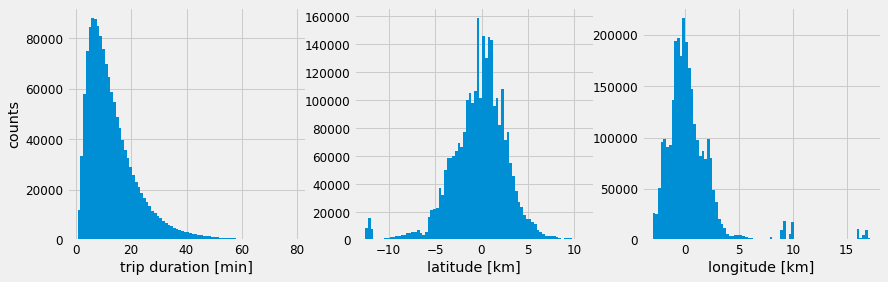

In [8]:
fig, axArray = plt.subplots(nrows=1,ncols=3,figsize=(13,4))
axArray[0].hist(data_frame['duration [min]'],80);
axArray[0].set_xlabel('trip duration [min]'); axArray[0].set_ylabel('counts')
axArray[1].hist(allLat ,80); axArray[1].set_xlabel('latitude [km]')
axArray[2].hist(allLong,80); axArray[2].set_xlabel('longitude [km]')
#위경도는 큰의미는 없지만 플랏으로 이상치가 있는지 시각적으로 확인 

### Plot the trip Duration vs. the Aerial Distance between pickup and dropoff

Text(0.5, 1.0, 'log of trip Duration vs Aerial trip Distance')

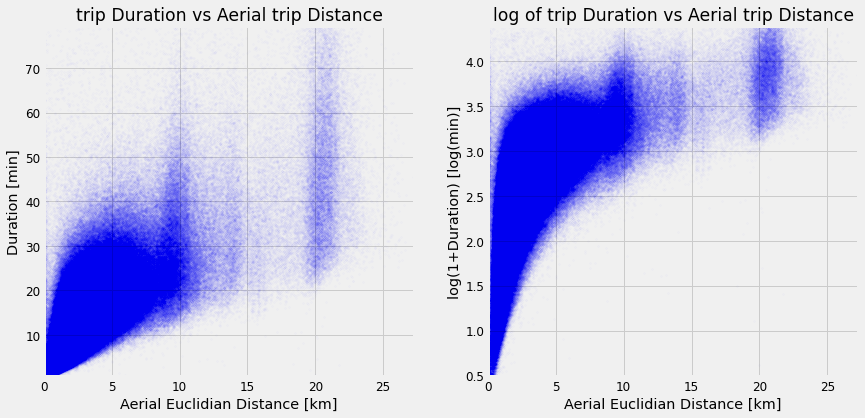

In [9]:
data_frame['log duration']       = np.log1p(data_frame['duration [min]'])
data_frame['euclidian distance'] = np.sqrt((data_frame['src lat [km]']  - data_frame['dst lat [km]'] )**2 +
                                       (data_frame['src long [km]'] - data_frame['dst long [km]'])**2)

fig, axArray = plt.subplots(nrows=1,ncols=2,figsize=(13,6))
axArray[0].scatter(data_frame['euclidian distance'], data_frame['duration [min]'],c='b',s=5,alpha=0.01);
axArray[0].set_xlabel('Aerial Euclidian Distance [km]'); axArray[0].set_ylabel('Duration [min]')
axArray[0].set_xlim(data_frame['euclidian distance'].min(),data_frame['euclidian distance'].max())
axArray[0].set_ylim(data_frame['duration [min]'].min(),data_frame['duration [min]'].max())
axArray[0].set_title('trip Duration vs Aerial trip Distance')

axArray[1].scatter(data_frame['euclidian distance'], data_frame['log duration'],c='b',s=5,alpha=0.01);
axArray[1].set_xlabel('Aerial Euclidian Distance [km]'); axArray[1].set_ylabel('log(1+Duration) [log(min)]')
axArray[1].set_xlim(data_frame['euclidian distance'].min(),data_frame['euclidian distance'].max())
axArray[1].set_ylim(data_frame['log duration'].min(),data_frame['log duration'].max())
axArray[1].set_title('log of trip Duration vs Aerial trip Distance')

### Exercise 1

위의 Scatter plot은 Point가 너무 많이 존재하여 좋은 시각화가 아닐 수 있습니다.
보다 효율적인 시각화 방안을 제시해 보세요.

matplotlib, seaborn, plotly 등 다양한 패키지를 활용할 수 있습니다

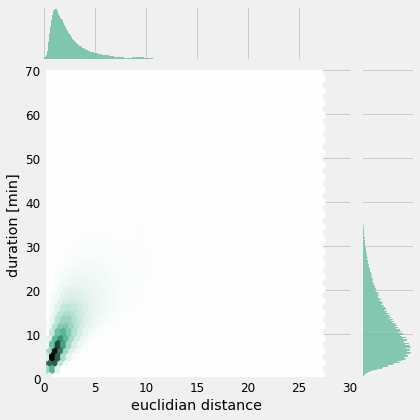

In [10]:
import seaborn as sns

sns.jointplot(x=data_frame['euclidian distance'], 
              y=data_frame['duration [min]'], 
              kind="hex", 
              color="#4CB391",
              xlim = (0,30),
              ylim = (0,70))

Text(8.060000000000002, 0.5, 'log(1+Duration) [log(min)]')

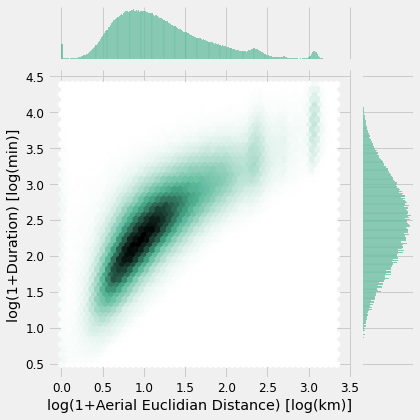

In [11]:
p = sns.jointplot(x=np.log1p(data_frame['euclidian distance']),
              y=data_frame['log duration'], 
              kind="hex", 
              color="#4CB391") #log를 취해 주어서 히트맵을 변환시켜 보여줌 

p.ax_joint.set_xlabel('log(1+Aerial Euclidian Distance) [log(km)]')
p.ax_joint.set_ylabel('log(1+Duration) [log(min)]')

We can see that the trip distance defines the lower bound on trip duration, as one would expect.

### Plot spatial density plot of the pickup and dropoff locations

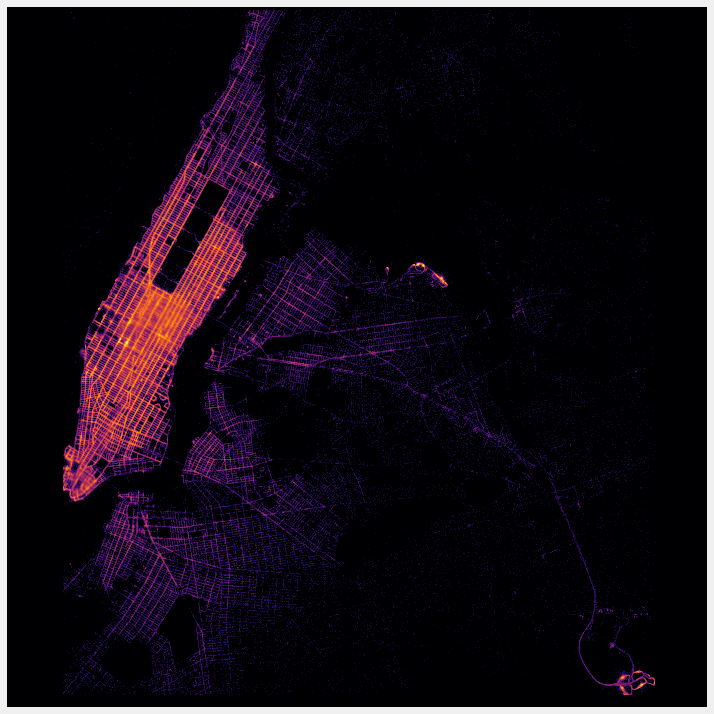

In [12]:
imageSize = (700,700)
longRange = [-5,19]
latRange = [-13,11]

allLatInds  = imageSize[0] - (imageSize[0] * (allLat  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
allLongInds =                (imageSize[1] * (allLong - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

locationDensityImage = np.zeros(imageSize)
for latInd, longInd in zip(allLatInds,allLongInds):
    locationDensityImage[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.imshow(np.log(locationDensityImage+1),cmap='inferno')
ax.set_axis_off()

### Exercise 2
folium이나 pydeck을 사용하여 택시의 승차지점, 하차지점을 시각화 해봅시다.
디서 승객이 많이 타고 내리는지를 확인할 수 있습니까?

In [13]:
data_frame.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,duration [min],src lat [km],src long [km],dst lat [km],dst long [km],log duration,euclidian distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,7.583333,1.516008,-0.110015,1.256121,1.367786,2.149822,1.500479
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,11.050000,-1.753813,0.036672,-2.578912,-1.571088,2.489065,1.807119
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,35.400000,1.070973,0.153763,-4.923841,-2.064547,3.594569,6.392080
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,7.150000,-3.823568,-2.461500,-5.298809,-2.649362,2.098018,1.487155
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,7.250000,4.329328,0.657515,3.139453,0.668452,2.110213,1.189925


In [14]:
data_frame.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'duration [min]', 'src lat [km]', 'src long [km]',
       'dst lat [km]', 'dst long [km]', 'log duration', 'euclidian distance'],
      dtype='object')

In [15]:
import pydeck as pdk

In [16]:
# Define a layer to display on a map
layer = pdk.Layer(
    "HexagonLayer",
    data_frame[:1000],
    get_position=["pickup_longitude", "pickup_latitude"],
    auto_highlight=True,
    elevation_scale=50,
    pickable=True,
    elevation_range=[0, 50],
    extruded=True,
    coverage=1,
)

# Set the viewport location
view_lon = np.mean(data_frame["pickup_longitude"])
view_lat = np.mean(data_frame["pickup_latitude"])

view_state = pdk.ViewState(
    longitude=view_lon, latitude=view_lat, zoom=10, min_zoom=5, max_zoom=15, pitch=40.5, bearing=-27.36,
)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.show()
#r.to_html("hexagon_ny_taxi.html")

DeckGLWidget(carto_key=None, custom_libraries=[], google_maps_key=None, json_input='{"initialViewState": {"bea…

In [17]:
layer = pdk.Layer(
    "HeatmapLayer",
    data_frame[:1000],
    get_position=["pickup_longitude", "pickup_latitude"],
    auto_highlight=True,
    elevation_scale=50,
    pickable=True,
    elevation_range=[0, 50],
    extruded=True,
    coverage=1,
)

# Set the viewport location
view_lon = np.mean(data_frame["pickup_longitude"])
view_lat = np.mean(data_frame["pickup_latitude"])

view_state = pdk.ViewState(
    longitude=view_lon, latitude=view_lat, zoom=10, min_zoom=5, max_zoom=15, pitch=40.5, bearing=-27.36,
)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.show()

DeckGLWidget(carto_key=None, custom_libraries=[], google_maps_key=None, json_input='{"initialViewState": {"bea…

In [18]:
#folium 을 이용해서도 예제로 해보기 

### Closing in on Manhattan

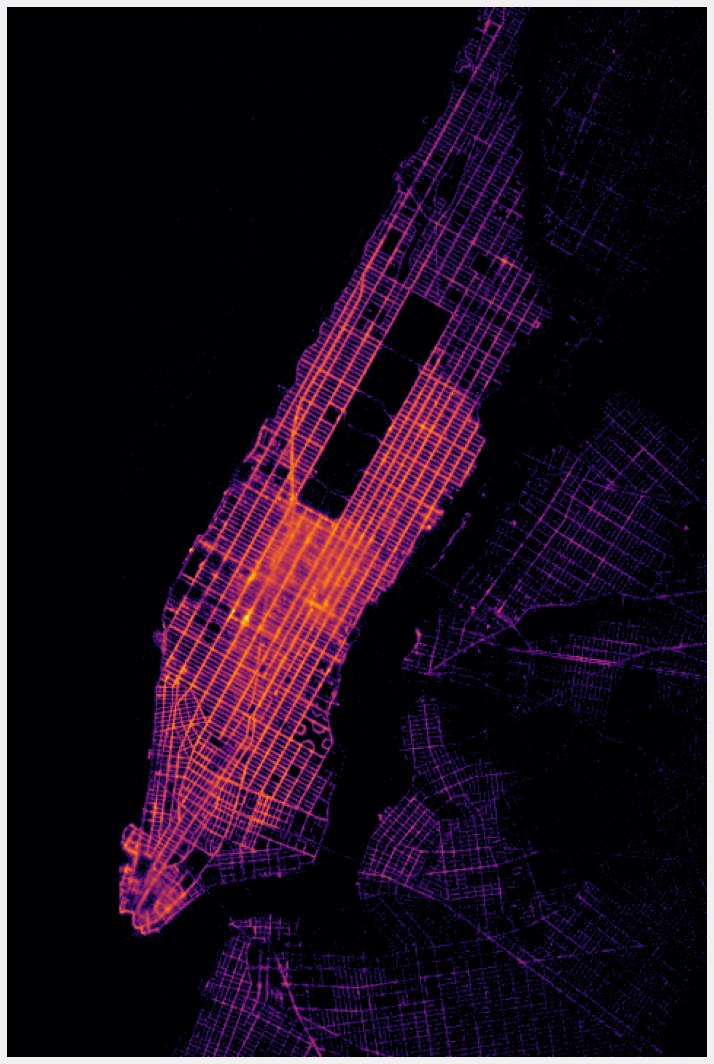

In [19]:
imageSizeMan = (720,480)
latRangeMan = [-8,10]
longRangeMan = [-5,7]

indToKeep  = np.logical_and(allLat > latRangeMan[0], allLat < latRangeMan[1])
indToKeep  = np.logical_and(indToKeep, np.logical_and(allLong > longRangeMan[0], allLong < longRangeMan[1]))
allLatMan  = allLat[indToKeep]
allLongMan = allLong[indToKeep]

allLatIndsMan  = (imageSizeMan[0]-1) - (imageSizeMan[0] * (allLatMan  - latRangeMan[0])
                                                        / (latRangeMan[1] - latRangeMan[0])).astype(int)
allLongIndsMan =                       (imageSizeMan[1] * (allLongMan - longRangeMan[0])
                                                        / (longRangeMan[1] - longRangeMan[0])).astype(int)

locationDensityImageMan = np.zeros(imageSizeMan)
for latInd, longInd in zip(allLatIndsMan,allLongIndsMan):
    locationDensityImageMan[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,18))
ax.imshow(np.log(locationDensityImageMan+1),cmap='inferno')
ax.set_axis_off()

### Cluster the Trips and Look at their distribution

In [20]:
pickupTime = pd.to_datetime(data_frame['pickup_datetime'])

data_frame['src hourOfDay'] = (pickupTime.dt.hour*60.0 + pickupTime.dt.minute)   / 60.0
data_frame['dst hourOfDay'] = data_frame['src hourOfDay'] + data_frame['duration [min]'] / 60.0

data_frame['dayOfWeek']     = pickupTime.dt.weekday
data_frame['hourOfWeek']    = data_frame['dayOfWeek']*24.0 + data_frame['src hourOfDay']

data_frame['monthOfYear']   = pickupTime.dt.month
data_frame['dayOfYear']     = pickupTime.dt.dayofyear
data_frame['weekOfYear']    = pickupTime.dt.weekofyear
data_frame['hourOfYear']    = data_frame['dayOfYear']*24.0 + data_frame['src hourOfDay']

<ipython-input-20-b78d8432b14c>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_frame['weekOfYear']    = pickupTime.dt.weekofyear


(0.0, 41.0)

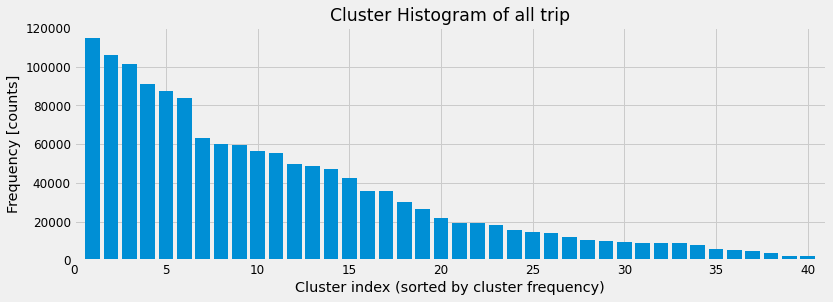

In [21]:
tripAttributes = np.array(data_frame.loc[:,['src lat [km]','src long [km]','dst lat [km]','dst long [km]','duration [min]']])
meanTripAttr = tripAttributes.mean(axis=0)
stdTripAttr  = tripAttributes.std(axis=0)
tripAttributes = stats.zscore(tripAttributes, axis=0)

numClusters = 40
TripKmeansModel = cluster.MiniBatchKMeans(n_clusters=numClusters, batch_size=120000, n_init=100, random_state=1)
clusterInds = TripKmeansModel.fit_predict(tripAttributes)

clusterTotalCounts, _ = np.histogram(clusterInds, bins=numClusters)
sortedClusterInds = np.flipud(np.argsort(clusterTotalCounts))

plt.figure(figsize=(12,4)); plt.title('Cluster Histogram of all trip')
plt.bar(range(1,numClusters+1),clusterTotalCounts[sortedClusterInds])
plt.ylabel('Frequency [counts]'); plt.xlabel('Cluster index (sorted by cluster frequency)')
plt.xlim(0,numClusters+1)

### Plot typical Trips on the Map

In [22]:
def ConvertToImageCoords(latCoord, longCoord, latRange, longRange, imageSize):
    latInds  = imageSize[0] - (imageSize[0] * (latCoord  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
    longInds =                (imageSize[1] * (longCoord - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

    return latInds, longInds

templateTrips = TripKmeansModel.cluster_centers_ * np.tile(stdTripAttr,(numClusters,1)) + np.tile(meanTripAttr,(numClusters,1))

srcCoords = templateTrips[:,:2]
dstCoords = templateTrips[:,2:4]

srcImCoords = ConvertToImageCoords(srcCoords[:,0],srcCoords[:,1], latRange, longRange, imageSize)
dstImCoords = ConvertToImageCoords(dstCoords[:,0],dstCoords[:,1], latRange, longRange, imageSize)

plt.figure(figsize=(12,12))
plt.imshow(np.log(locationDensityImage+1),cmap='inferno'); plt.grid('off')
plt.scatter(srcImCoords[1],srcImCoords[0],c='m',s=200,alpha=0.8)
plt.scatter(dstImCoords[1],dstImCoords[0],c='g',s=200,alpha=0.8)

for i in range(len(srcImCoords[0])):
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i],
              edgecolor='c', facecolor='c', width=0.8,alpha=0.4,head_width=10.0,head_length=10.0,length

SyntaxError: unexpected EOF while parsing (<ipython-input-22-39197d099a2f>, line 22)

### Calculate the trip distribution for different hours of the weekday

In [ ]:
hoursOfDay = np.sort(data_frame['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekday = np.zeros((len(hoursOfDay),numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (data_frame['src hourOfDay'].astype(int) == hour) & (data_frame['dayOfWeek'] <= 4)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfDay_weekday[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
ax.set_title('Trip Distribution during Weekdays', fontsize=12)
ax.imshow(clusterDistributionHourOfDay_weekday); ax.grid('off')
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Hour of Day')

### Calculate the trip distribution for different hours of the weekend

In [ ]:
hoursOfDay = np.sort(data_frame['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekend = np.zeros((len(hoursOfDay),numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (data_frame['src hourOfDay'].astype(int) == hour) & (data_frame['dayOfWeek'] >= 5)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfDay_weekend[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
ax.set_title('Trip Distribution during Weekends', fontsize=12)
ax.imshow(clusterDistributionHourOfDay_weekend); ax.grid('off')
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Hour of Day')

### Calculate the trip distribution for day of week

In [ ]:
daysOfWeek = np.sort(data_frame['dayOfWeek'].unique())
clusterDistributionDayOfWeek = np.zeros((len(daysOfWeek),numClusters))
for k, day in enumerate(daysOfWeek):
    slectedInds = data_frame['dayOfWeek'] == day
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionDayOfWeek[k,:] = currDistribution[sortedClusterInds]

plt.figure(figsize=(12,5)); plt.title('Trip Distribution throughout the Week')
plt.imshow(clusterDistributionDayOfWeek); plt.grid('off')
plt.xlabel('Trip Cluster'); plt.ylabel('Day of Week')

### Calculate the trip distribution for day of year

In [ ]:
daysOfYear = data_frame['dayOfYear'].unique()
daysOfYear = np.sort(daysOfYear)
clusterDistributionDayOfYear = np.zeros((len(daysOfYear),numClusters))
for k, day in enumerate(daysOfYear):
    slectedInds = data_frame['dayOfYear'] == day
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionDayOfYear[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,16))
ax.set_title('Trip Distribution throughout the Year', fontsize=12)
ax.imshow(clusterDistributionDayOfYear); ax.grid('off')
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Day of Year')
ax.annotate('Large Snowstorm', color='r', fontsize=15 ,xy=(5, 21), xytext=(20, 17),
            arrowprops=dict(facecolor='red', shrink=0.03))
ax.annotate('Memorial Day', color='r', fontsize=15, xy=(5, 151), xytext=(20, 157),
            arrowprops=dict(facecolor='red', shrink=0.03))

### Computing PCA coefficients

In [ ]:
hoursOfYear = np.sort(data_frame['hourOfYear'].astype(int).unique())
clusterDistributionHourOfYear = np.zeros((len(range(hoursOfYear[0],hoursOfYear[-1])),numClusters))
dayOfYearVec  = np.zeros(clusterDistributionHourOfYear.shape[0])
weekdayVec    = np.zeros(clusterDistributionHourOfYear.shape[0])
weekOfYearVec = np.zeros(clusterDistributionHourOfYear.shape[0])
for k, hour in enumerate(hoursOfYear):
    slectedInds = data_frame['hourOfYear'].astype(int) == hour
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfYear[k,:] = currDistribution[sortedClusterInds]

    dayOfYearVec[k]  = data_frame[slectedInds]['dayOfYear'].mean()
    weekdayVec[k]    = data_frame[slectedInds]['dayOfWeek'].mean()
    weekOfYearVec[k] = data_frame[slectedInds]['weekOfYear'].mean()

numComponents = 3
TripDistributionPCAModel = decomposition.PCA(n_components=numComponents,whiten=True, random_state=1)
compactClusterDistributionHourOfYear = TripDistributionPCAModel.fit_transform(clusterDistributionHourOfYear)

### Collect traces for all weeks of year

In [ ]:
listOfFullWeeks = []
for uniqueVal in np.unique(weekOfYearVec):
    if (weekOfYearVec == uniqueVal).sum() == 24*7:
        listOfFullWeeks.append(uniqueVal)

weeklyTraces = np.zeros((24*7,numComponents,len(listOfFullWeeks)))
for k, weekInd in enumerate(listOfFullWeeks):
    weeklyTraces[:,:,k] = compactClusterDistributionHourOfYear[weekOfYearVec == weekInd,:]

fig, axArray = plt.subplots(nrows=numComponents,ncols=1,sharex=True, figsize=(10,10))
fig.suptitle('PCA coefficients during the Week', fontsize=25)
for PC_coeff in range(numComponents):
    meanTrace = weeklyTraces[:,PC_coeff,:].mean(axis=1)
    axArray[PC_coeff].plot(weeklyTraces[:,PC_coeff,:],'red',linewidth=1.5)
    axArray[PC_coeff].plot(meanTrace,'k',linewidth=2.5)
    axArray[PC_coeff].set_ylabel('PC %d coeff' %(PC_coeff+1))
    axArray[PC_coeff].vlines([0,23,47,71,95,119,143,167], weeklyTraces[:,PC_coeff,:].min(), weeklyTraces[:,PC_coeff,:].max(), colors='black', lw=2)

axArray[PC_coeff].set_xlabel('hours since start of week')
axArray[PC_coeff].set_xlim(-0.9,24*7-0.1)

### Examine what different PC coefficients mean by looking at their trip template distributions

In [ ]:
fig, axArray = plt.subplots(nrows=numComponents,ncols=1,sharex=True, figsize=(12,11))
fig.suptitle('Trip Distribution PCA Components', fontsize=25)
for PC_coeff in range(numComponents):
    tripTemplateDistributionDifference = TripDistributionPCAModel.components_[PC_coeff,:] * \
                                         TripDistributionPCAModel.explained_variance_[PC_coeff]
    axArray[PC_coeff].bar(range(1,numClusters+1),tripTemplateDistributionDifference)
    axArray[PC_coeff].set_title('PCA %d component' %(PC_coeff+1))
    axArray[PC_coeff].set_ylabel('delta frequency [counts]')
    
axArray[PC_coeff].set_xlabel('cluster index (sorted by cluster frequency)')
axArray[PC_coeff].set_xlim(0,numClusters+0.5)

axArray[1].hlines([-25,25], 0, numClusters+0.5, colors='r', lw=0.7)
axArray[2].hlines([-11,11], 0, numClusters+0.5, colors='r', lw=0.7)

We can see that the first PCA component looks very similar to the overall trip distribution, suggesting that it's mainly a "gain" component that controls just the number of total trips in that period of time.